## Event based

In [37]:
import climtas
import dask.array
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sparse
import xarray as xr

In [2]:
# opening the input files with heatwave severity data 
thw = xr.open_dataset('/g/data/e14/cp3790/Charuni/Tasmania/aus-coastal-sev.nc')
mhw = xr.open_dataset('/g/data/e14/cp3790/Charuni/Tasmania/aus-ocean-sev-2.nc')

In [3]:
# using climtas.event.find_events to identify days where severity>1 for a minimum of 3 consecutive days 
thw_events = climtas.event.find_events(thw.severity > 1, min_duration = 3)
thw_events

,time,latitude,longitude,event_duration
0,0,48,151,3
1,0,48,152,3
2,0,50,152,3
3,0,54,154,3
4,0,54,155,3
...,...,...,...,...
165334,13508,130,142,6
165335,13508,130,143,6
165336,13508,131,142,6
165337,13508,133,140,6


In [4]:
# Create a sparse array with (coords, values, shape)
event_duration_array = sparse.COO([thw_events['time'], thw_events['latitude'], thw_events['longitude']], thw_events['event_duration'], shape=thw.severity.shape)
event_duration_da = xr.DataArray(event_duration_array, coords=thw.severity.coords)
event_duration_da

Format,coo
Data Type,int64
Shape,"(13514, 137, 165)"
nnz,165339
Density,0.0005412362553753639
Read-only,True
Size,5.0M
Storage ratio,0.0


In [5]:
def get_coords(da, events):
    # Convert the index values to coordinates
    coords = {}
    for d in da.dims:
        coords[d] = da[d].values[events[d].values]
    
    # Also work out when the event ends
    coords['time_end'] = da['time'].values[events['time'].values + events['event_duration'].values-1]
    #coords['event_duration'] = coords['time_end'] - coords['time'] 
    coords['event_duration'] = events['event_duration'].values
    
    return pd.DataFrame(coords, index=events.index)

In [14]:
def get_coords(da, events):
    # Convert the index values to coordinates
    coords = {}
    for d in da.dims:
        coords[d] = da[d].values[events[d].values]
    
    # Also work out when the event ends
    coords['time_end'] = da['time'].values[events['time'].values + events['event_duration'].values-1]
    #coords['event_duration'] = coords['time_end'] - coords['time'] 
    coords['event_duration'] = events['event_duration'].values
    #coords['severity'] = da['severity'].mean()
    events.query(time:time_end).groupby('severity').mean()
    return pd.DataFrame(coords, index=events.index)

SyntaxError: invalid syntax (<ipython-input-14-c6f071dc0581>, line 12)

In [6]:
thw_new = get_coords(event_duration_da, thw_events)
thw_new

,time,latitude,longitude,time_end,event_duration
0,1982-01-01,-22.00,150.75,1982-01-03,3
1,1982-01-01,-22.00,151.00,1982-01-03,3
2,1982-01-01,-22.50,151.00,1982-01-03,3
3,1982-01-01,-23.50,151.50,1982-01-03,3
4,1982-01-01,-23.50,151.75,1982-01-03,3
...,...,...,...,...,...
165334,2018-12-26,-42.50,148.50,2018-12-31,6
165335,2018-12-26,-42.50,148.75,2018-12-31,6
165336,2018-12-26,-42.75,148.50,2018-12-31,6
165337,2018-12-26,-43.25,148.00,2018-12-31,6


In [7]:
thw_new_df = thw_new.reset_index()
thw_new_df.set_index(['latitude', 'longitude'], inplace=True)
thw_new_df

index       time   time_end  event_duration
latitude longitude                                              
-22.00   150.75          0 1982-01-01 1982-01-03               3
         151.00          1 1982-01-01 1982-01-03               3
-22.50   151.00          2 1982-01-01 1982-01-03               3
-23.50   151.50          3 1982-01-01 1982-01-03               3
         151.75          4 1982-01-01 1982-01-03               3
...                    ...        ...        ...             ...
-42.50   148.50     165334 2018-12-26 2018-12-31               6
         148.75     165335 2018-12-26 2018-12-31               6
-42.75   148.50     165336 2018-12-26 2018-12-31               6
-43.25   148.00     165337 2018-12-26 2018-12-31               6
         148.25     165338 2018-12-26 2018-12-31               6

[165339 rows x 4 columns]

In [8]:
# using climtas.event.find_events to identify days where severity>1 for a minimum of 5 consecutive days (MHW events)
mhw_events = climtas.event.find_events(mhw.severity > 1, min_duration = 5)
mhw_events

,time,latitude,longitude,event_duration
0,0,0,29,5
1,0,1,123,5
2,0,1,124,5
3,0,4,94,5
4,0,4,95,5
...,...,...,...,...
127727,13497,135,133,17
127728,13500,135,134,14
127729,13500,135,135,14
127730,13491,135,136,23


In [9]:
mhw_duration_array = sparse.COO([mhw_events['time'], mhw_events['latitude'], mhw_events['longitude']], mhw_events['event_duration'], shape=mhw.severity.shape)
mhw_duration_da = xr.DataArray(event_duration_array, coords=mhw.severity.coords)
mhw_duration_da

Format,coo
Data Type,int64
Shape,"(13514, 137, 165)"
nnz,165339
Density,0.0005412362553753639
Read-only,True
Size,5.0M
Storage ratio,0.0


In [10]:
mhw_new = get_coords(mhw_duration_da, mhw_events)
mhw_new

,time,latitude,longitude,time_end,event_duration
0,1982-01-01,-10.00,120.25,1982-01-05,5
1,1982-01-01,-10.25,143.75,1982-01-05,5
2,1982-01-01,-10.25,144.00,1982-01-05,5
3,1982-01-01,-11.00,136.50,1982-01-05,5
4,1982-01-01,-11.00,136.75,1982-01-05,5
...,...,...,...,...,...
127727,2018-12-15,-43.75,146.25,2018-12-31,17
127728,2018-12-18,-43.75,146.50,2018-12-31,14
127729,2018-12-18,-43.75,146.75,2018-12-31,14
127730,2018-12-09,-43.75,147.00,2018-12-31,23


In [11]:
mhw_new_df = mhw_new.reset_index()
mhw_new_df.set_index(['latitude', 'longitude'], inplace=True)
mhw_new_df

index       time   time_end  event_duration
latitude longitude                                              
-10.00   120.25          0 1982-01-01 1982-01-05               5
-10.25   143.75          1 1982-01-01 1982-01-05               5
         144.00          2 1982-01-01 1982-01-05               5
-11.00   136.50          3 1982-01-01 1982-01-05               5
         136.75          4 1982-01-01 1982-01-05               5
...                    ...        ...        ...             ...
-43.75   146.25     127727 2018-12-15 2018-12-31              17
         146.50     127728 2018-12-18 2018-12-31              14
         146.75     127729 2018-12-18 2018-12-31              14
         147.00     127730 2018-12-09 2018-12-31              23
         147.25     127731 2018-12-13 2018-12-31              19

[127732 rows x 4 columns]

In [13]:
# merging the THW and MHW dataframes based on latitude and longitude 
df_merge_col = pd.merge(thw_new_df, mhw_new_df, on=['latitude', 'longitude'])
df_merge_col

index_x     time_x time_end_x  event_duration_x  index_y  \
latitude longitude                                                             
-22.0    150.75           0 1982-01-01 1982-01-03                 3      149   
         150.75           0 1982-01-01 1982-01-03                 3      557   
         150.75           0 1982-01-01 1982-01-03                 3     1008   
         150.75           0 1982-01-01 1982-01-03                 3     1291   
         150.75           0 1982-01-01 1982-01-03                 3     1615   
...                     ...        ...        ...               ...      ...   
-29.5    153.50      164567 2018-12-13 2018-12-15                 3   125538   
         153.50      164567 2018-12-13 2018-12-15                 3   126077   
         153.50      164567 2018-12-13 2018-12-15                 3   126430   
         153.50      164567 2018-12-13 2018-12-15                 3   126659   
         153.50      164567 2018-12-13 2018-12-15                 3   127100   

                       time_y time_end_y  event_duration_y  
latitude longitude                                          
-22.0    150.75    1982-01-02 1982-01-08                 7  
         150.75    1982-01-18 1982-01-26                 9  
         150.75    1982-03-04 1982-03-12                 9  
         150.75    1982-03-16 1982-03-21                 6  
         150.75    1982-03-29 1982-04-05                 8  
...                       ...        ...               ...  
-29.5    153.50    2018-03-30 2018-04-29                31  
         153.50    2018-06-10 2018-06-16                 7  
         153.50    2018-08-08 2018-08-15                 8  
         153.50    2018-09-21 2018-09-25                 5  
         153.50    2018-10-19 2018-11-18                31  

[22207677 rows x 8 columns]

In [14]:
del df_merge_col['index_y']
del df_merge_col['index_x']
df_merge_col

time_x time_end_x  event_duration_x     time_y  \
latitude longitude                                                      
-22.0    150.75    1982-01-01 1982-01-03                 3 1982-01-02   
         150.75    1982-01-01 1982-01-03                 3 1982-01-18   
         150.75    1982-01-01 1982-01-03                 3 1982-03-04   
         150.75    1982-01-01 1982-01-03                 3 1982-03-16   
         150.75    1982-01-01 1982-01-03                 3 1982-03-29   
...                       ...        ...               ...        ...   
-29.5    153.50    2018-12-13 2018-12-15                 3 2018-03-30   
         153.50    2018-12-13 2018-12-15                 3 2018-06-10   
         153.50    2018-12-13 2018-12-15                 3 2018-08-08   
         153.50    2018-12-13 2018-12-15                 3 2018-09-21   
         153.50    2018-12-13 2018-12-15                 3 2018-10-19   

                   time_end_y  event_duration_y  
latitude longitude                               
-22.0    150.75    1982-01-08                 7  
         150.75    1982-01-26                 9  
         150.75    1982-03-12                 9  
         150.75    1982-03-21                 6  
         150.75    1982-04-05                 8  
...                       ...               ...  
-29.5    153.50    2018-04-29                31  
         153.50    2018-06-16                 7  
         153.50    2018-08-15                 8  
         153.50    2018-09-25                 5  
         153.50    2018-11-18                31  

[22207677 rows x 6 columns]

In [15]:
#Calculating the overlap between THW and MHW events 
from datetime import datetime
from collections import namedtuple
Range = namedtuple('Range', ['start', 'end'])
overlap = []
for n in range (df_merge_col.shape[0]):
    mhw = Range(start=df_merge_col['time_y'][n], end=df_merge_col['time_end_y'][n])
    thw = Range(start=df_merge_col['time_x'][n], end=df_merge_col['time_end_x'][n])
    latest_start = max(mhw.start, thw.start)
    earliest_end = min(mhw.end, thw.end)
    delta = (earliest_end - latest_start).days + 1
    b = max(0, delta)
    overlap.append(b)

In [23]:
#Retaining only the THW events which had an overlap of at least one day with a MHW event; these are the co-occurring events
test = mod_fd[mod_fd.overlap_days != 0].reset_index()
test

,latitude,longitude,time_x,time_end_x,event_duration_x,time_y,time_end_y,event_duration_y,overlap_days
0,-22.0,150.75,1982-01-01,1982-01-03,3,1982-01-02,1982-01-08,7,2
1,-22.0,150.75,1982-03-03,1982-03-08,6,1982-03-04,1982-03-12,9,5
2,-22.0,150.75,1982-03-12,1982-03-14,3,1982-03-04,1982-03-12,9,1
3,-22.0,150.75,1982-04-04,1982-04-06,3,1982-03-29,1982-04-05,8,2
4,-22.0,150.75,1983-04-04,1983-04-11,8,1983-03-31,1983-04-04,5,1
...,...,...,...,...,...,...,...,...,...
63609,-29.5,153.50,2017-09-03,2017-09-06,4,2017-08-30,2017-09-04,6,2
63610,-29.5,153.50,2017-09-12,2017-09-14,3,2017-09-08,2017-09-12,5,1
63611,-29.5,153.50,2017-09-27,2017-09-30,4,2017-09-27,2017-10-11,15,4
63612,-29.5,153.50,2018-02-13,2018-02-16,4,2018-02-15,2018-02-20,6,2


In [24]:
import numpy as np
newpt=(np.NaN,np.NaN)
event_pt=[]
nevent=0
for pt in zip(test['latitude'],test['longitude']):
    if pt != newpt:
        nevent=0
        newpt=pt
    else:
        nevent=nevent+1
    event_pt.append(nevent)
len(event_pt)

63614

In [25]:
test['event'] = event_pt
test

,latitude,longitude,time_x,time_end_x,event_duration_x,time_y,time_end_y,event_duration_y,overlap_days,event
0,-22.0,150.75,1982-01-01,1982-01-03,3,1982-01-02,1982-01-08,7,2,0
1,-22.0,150.75,1982-03-03,1982-03-08,6,1982-03-04,1982-03-12,9,5,1
2,-22.0,150.75,1982-03-12,1982-03-14,3,1982-03-04,1982-03-12,9,1,2
3,-22.0,150.75,1982-04-04,1982-04-06,3,1982-03-29,1982-04-05,8,2,3
4,-22.0,150.75,1983-04-04,1983-04-11,8,1983-03-31,1983-04-04,5,1,4
...,...,...,...,...,...,...,...,...,...,...
63609,-29.5,153.50,2017-09-03,2017-09-06,4,2017-08-30,2017-09-04,6,2,41
63610,-29.5,153.50,2017-09-12,2017-09-14,3,2017-09-08,2017-09-12,5,1,42
63611,-29.5,153.50,2017-09-27,2017-09-30,4,2017-09-27,2017-10-11,15,4,43
63612,-29.5,153.50,2018-02-13,2018-02-16,4,2018-02-15,2018-02-20,6,2,44


In [26]:
test.set_index(['event', 'latitude', 'longitude'], inplace=True)
test

,,,time_x,time_end_x,event_duration_x,time_y,time_end_y,event_duration_y,overlap_days
event,latitude,longitude,,,,,,,
0,-22.0,150.75,1982-01-01,1982-01-03,3,1982-01-02,1982-01-08,7,2
1,-22.0,150.75,1982-03-03,1982-03-08,6,1982-03-04,1982-03-12,9,5
2,-22.0,150.75,1982-03-12,1982-03-14,3,1982-03-04,1982-03-12,9,1
3,-22.0,150.75,1982-04-04,1982-04-06,3,1982-03-29,1982-04-05,8,2
4,-22.0,150.75,1983-04-04,1983-04-11,8,1983-03-31,1983-04-04,5,1
...,...,...,...,...,...,...,...,...,...
41,-29.5,153.50,2017-09-03,2017-09-06,4,2017-08-30,2017-09-04,6,2
42,-29.5,153.50,2017-09-12,2017-09-14,3,2017-09-08,2017-09-12,5,1
43,-29.5,153.50,2017-09-27,2017-09-30,4,2017-09-27,2017-10-11,15,4


In [27]:
ds = test.to_xarray()

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


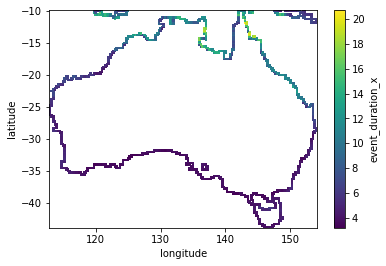

In [135]:
ds['event_duration_x'].mean(dim=['event']).plot()

In [29]:
#Where there is no overlap between events, these are the stand alone THW events
thw = mod_fd[mod_fd.overlap_days == 0].reset_index()
thw

,latitude,longitude,time_x,time_end_x,event_duration_x,time_y,time_end_y,event_duration_y,overlap_days
0,-22.0,150.75,1982-01-01,1982-01-03,3,1982-01-18,1982-01-26,9,0
1,-22.0,150.75,1982-01-01,1982-01-03,3,1982-03-04,1982-03-12,9,0
2,-22.0,150.75,1982-01-01,1982-01-03,3,1982-03-16,1982-03-21,6,0
3,-22.0,150.75,1982-01-01,1982-01-03,3,1982-03-29,1982-04-05,8,0
4,-22.0,150.75,1982-01-01,1982-01-03,3,1983-03-31,1983-04-04,5,0
...,...,...,...,...,...,...,...,...,...
22144058,-29.5,153.50,2018-12-13,2018-12-15,3,2018-03-30,2018-04-29,31,0
22144059,-29.5,153.50,2018-12-13,2018-12-15,3,2018-06-10,2018-06-16,7,0
22144060,-29.5,153.50,2018-12-13,2018-12-15,3,2018-08-08,2018-08-15,8,0
22144061,-29.5,153.50,2018-12-13,2018-12-15,3,2018-09-21,2018-09-25,5,0


In [30]:
import numpy as np
newpt=(np.NaN,np.NaN)
event_pt=[]
nevent=0
for pt in zip(thw['latitude'],thw['longitude']):
    if pt != newpt:
        nevent=0
        newpt=pt
    else: 
        nevent=nevent+1
    event_pt.append(nevent)
len(event_pt)

22144063

In [31]:
thw['event']=event_pt
thw

,latitude,longitude,time_x,time_end_x,event_duration_x,time_y,time_end_y,event_duration_y,overlap_days,event
0,-22.0,150.75,1982-01-01,1982-01-03,3,1982-01-18,1982-01-26,9,0,0
1,-22.0,150.75,1982-01-01,1982-01-03,3,1982-03-04,1982-03-12,9,0,1
2,-22.0,150.75,1982-01-01,1982-01-03,3,1982-03-16,1982-03-21,6,0,2
3,-22.0,150.75,1982-01-01,1982-01-03,3,1982-03-29,1982-04-05,8,0,3
4,-22.0,150.75,1982-01-01,1982-01-03,3,1983-03-31,1983-04-04,5,0,4
...,...,...,...,...,...,...,...,...,...,...
22144058,-29.5,153.50,2018-12-13,2018-12-15,3,2018-03-30,2018-04-29,31,0,22765
22144059,-29.5,153.50,2018-12-13,2018-12-15,3,2018-06-10,2018-06-16,7,0,22766
22144060,-29.5,153.50,2018-12-13,2018-12-15,3,2018-08-08,2018-08-15,8,0,22767
22144061,-29.5,153.50,2018-12-13,2018-12-15,3,2018-09-21,2018-09-25,5,0,22768


In [32]:
thw.set_index(['event','latitude', 'longitude'], inplace=True)
thw

,,,time_x,time_end_x,event_duration_x,time_y,time_end_y,event_duration_y,overlap_days
event,latitude,longitude,,,,,,,
0,-22.0,150.75,1982-01-01,1982-01-03,3,1982-01-18,1982-01-26,9,0
1,-22.0,150.75,1982-01-01,1982-01-03,3,1982-03-04,1982-03-12,9,0
2,-22.0,150.75,1982-01-01,1982-01-03,3,1982-03-16,1982-03-21,6,0
3,-22.0,150.75,1982-01-01,1982-01-03,3,1982-03-29,1982-04-05,8,0
4,-22.0,150.75,1982-01-01,1982-01-03,3,1983-03-31,1983-04-04,5,0
...,...,...,...,...,...,...,...,...,...
22765,-29.5,153.50,2018-12-13,2018-12-15,3,2018-03-30,2018-04-29,31,0
22766,-29.5,153.50,2018-12-13,2018-12-15,3,2018-06-10,2018-06-16,7,0
22767,-29.5,153.50,2018-12-13,2018-12-15,3,2018-08-08,2018-08-15,8,0


In [35]:
ds_thw = thw.to_xarray()

MemoryError: Unable to allocate 7.20 GiB for an array with shape (43090, 136, 165) and data type datetime64[ns]